<a href="https://colab.research.google.com/github/billcai/mmclassify-tutorial/blob/master/food_model_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using a Trained Model to Infer on Images

## Environment Setup
First, we install prerequisite packages

In [ ]:
!pip install mmcv
!git clone https://github.com/open-mmlab/mmclassification.git && cd mmclassification && pip install -e .
!pip install gdown
import sys, os
sys.path.append(os.path.join(os.getcwd(),'mmclassification'))

fatal: destination path 'mmclassification' already exists and is not an empty directory.


In [ ]:
import gdown
# downloading trained model weights with gdown
model_url = 'https://drive.google.com/uc?id=1E1qD1BJ3NM8Jk1lWWTatdTz2ofkqVp1y'
local_file = 'model.pth'
gdown.download(model_url,local_file,quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1E1qD1BJ3NM8Jk1lWWTatdTz2ofkqVp1y
To: /content/model.pth
11.1MB [00:00, 35.4MB/s]


'model.pth'

In [ ]:
classes_url = 'https://drive.google.com/uc?id=17UN-0d9xSgHSFL-IAd8hbt7xVpYMc8FH'
local_file = 'classes.txt'
gdown.download(classes_url,local_file,quiet=False)

Downloading...
From: https://drive.google.com/uc?id=17UN-0d9xSgHSFL-IAd8hbt7xVpYMc8FH
To: /content/classes.txt
100%|██████████| 1.18k/1.18k [00:00<00:00, 421kB/s]


'classes.txt'

## Inference Setup
This config file needs to match the same one as the one used in training

In [ ]:
from mmcv import Config, DictAction
cfg = Config.fromfile(
    'mmclassification/configs/shufflenet_v2/shufflenet_v2_1x_b64x16_linearlr_bn_nowd_imagenet.py')
cfg.model.head.num_classes = 101

In [ ]:
# loading model weights
from mmcls.apis import init_model, inference_model
model = init_model(cfg,'model.pth')

Use load_from_local loader


/content/mmclassification/mmcls/apis/inference.py:44: UserWarning: Class names are not saved in the checkpoint's meta data, use imagenet by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


In [ ]:
# loading model classes based on classes.txt
model.CLASSES = []
with open('classes.txt') as f:
    for x in f.readlines():
        model.CLASSES.append(x[:-1])

In [ ]:
model.CLASSES

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [ ]:
# downloading sample images
import requests
import shutil 
import mmcv, matplotlib.pyplot as plt

def download_image(image_url,filename):
    r = requests.get(image_url, stream = True)
    if r.status_code == 200:
        r.raw.decode_content = True
        with open(filename,'wb') as f:
            shutil.copyfileobj(r.raw, f)
        print('Image sucessfully Downloaded: ',filename)
        img = mmcv.imread(filename)
        plt.imshow(mmcv.bgr2rgb(img))
        plt.show()
        return True
    else:
        print('Image Couldn\'t be retreived')
        return False

Image sucessfully Downloaded:  McSpicy.jpg


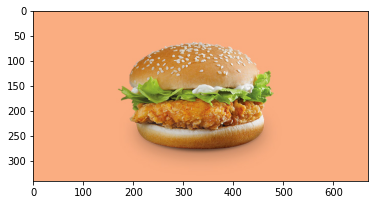

Image sucessfully Downloaded:  ApplePie.jpg


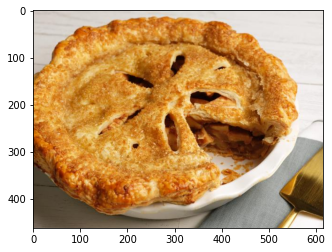

Image sucessfully Downloaded:  Salad.jpg


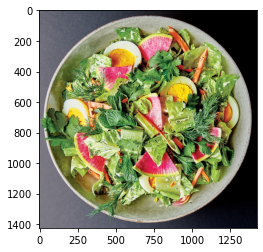

Image sucessfully Downloaded:  Mr-Coconut.jpg


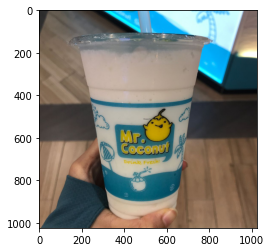

Image sucessfully Downloaded:  Cheesecake.jpg


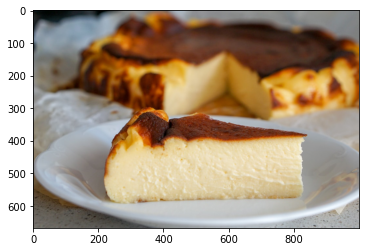

Image sucessfully Downloaded:  BakChorMee.jpg


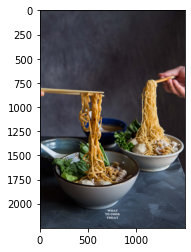

True

In [ ]:
download_image(
    "https://m.buro247.sg/images/lifestyle/mcspicy-mcds-cra.jpg",
    "McSpicy.jpg"
)
download_image(
    "https://food.fnr.sndimg.com/content/dam/images/food/fullset/2019/7/11/0/FNK_the-best-apple-pie_H_s4x3.jpg.rend.hgtvcom.616.462.suffix/1562853900284.jpeg",
    "ApplePie.jpg"
)
download_image(
    "https://assets.bonappetit.com/photos/5e8cdb60a7a01c00083b08a9/1:1/w_2560%2Cc_limit/HMONG-Potluck-Chopped-Salad.jpg",
    "Salad.jpg"
)
download_image(
    "https://images.happycow.net/venues/1024/11/33/hcmp113353_367000.jpeg",
    "Mr-Coconut.jpg"
)
download_image(
    "https://spanishsabores.com/wp-content/uploads/2020/05/DSC08145.jpg",
    "Cheesecake.jpg"
)
download_image(
    "https://whattocooktoday.com/wp-content/uploads/2016/08/IMG_0414.jpg",
    "BakChorMee.jpg"
)


In [ ]:
from mmcls.datasets.pipelines import Compose
from mmcv.parallel import collate, scatter
import torch
import numpy as np

# we modify the default inference function so that we get the top n results
def inference_model(model, img):
    """Inference image(s) with the classifier.
    Args:
        model (nn.Module): The loaded classifier.
        img (str/ndarray): The image filename or loaded image.
    Returns:
        result (dict): The classification results that contains
            `class_name`, `pred_label` and `pred_score`.
    """
    cfg = model.cfg
    device = next(model.parameters()).device  # model device
    # build the data pipeline
    if isinstance(img, str):
        if cfg.data.test.pipeline[0]['type'] != 'LoadImageFromFile':
            cfg.data.test.pipeline.insert(0, dict(type='LoadImageFromFile'))
        data = dict(img_info=dict(filename=img), img_prefix=None)
    else:
        if cfg.data.test.pipeline[0]['type'] == 'LoadImageFromFile':
            cfg.data.test.pipeline.pop(0)
        data = dict(img=img)
    test_pipeline = Compose(cfg.data.test.pipeline)
    data = test_pipeline(data)
    data = collate([data], samples_per_gpu=1)
    if next(model.parameters()).is_cuda:
        # scatter to specified GPU
        data = scatter(data, [device])[0]

    # forward the model
    with torch.no_grad():
        scores = model(return_loss=False, **data)
        results = []
        for i in range(5):
            pred_score = np.max(scores, axis=1)[0]
            pred_label = np.argmax(scores, axis=1)[0]
            result = {'pred_label': pred_label, 'pred_score': float(pred_score)}
            result['pred_class'] = model.CLASSES[result['pred_label']]
            results.append(result)
            scores[0][pred_label] = -999999
    return results

In [ ]:
result = inference_model(model,'ApplePie.jpg')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
result

[{'pred_class': 'apple_pie',
  'pred_label': 0,
  'pred_score': 0.3481855094432831},
 {'pred_class': 'omelette',
  'pred_label': 67,
  'pred_score': 0.10955636203289032},
 {'pred_class': 'grilled_cheese_sandwich',
  'pred_label': 49,
  'pred_score': 0.08935672789812088},
 {'pred_class': 'chicken_quesadilla',
  'pred_label': 19,
  'pred_score': 0.0728083923459053},
 {'pred_class': 'hummus', 'pred_label': 57, 'pred_score': 0.03948130086064339}]